# Loads packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

## Loads the Database

In [6]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = torch.tensor((df[df.columns[3:]].to_numpy())).float()

  return dataIdentifier, trainInfo, df
dataIdentifier, trainInfo, df = preprocessData()

props = df.columns[3:].tolist()
nmat, nprop = trainInfo.size()

## Loads the truss

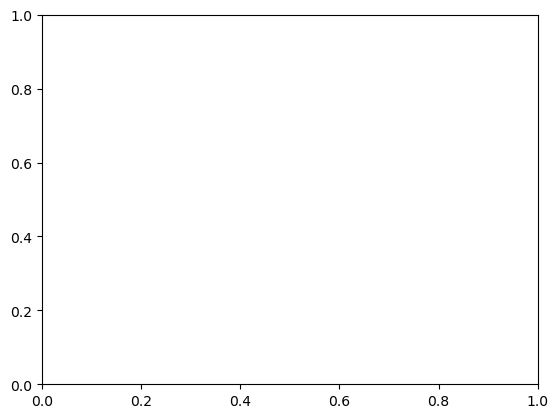

In [7]:
from examples import getExample
from truss3DFE import Truss3DFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(19)
#Changes the force
bc['forces'] = {'nodes':np.array([8]), 'fx':1.E3*torch.tensor([0.]), 'fy':1E2*torch.tensor([200.]), 'fz':1E0*torch.tensor([0.])}


n_bars=len(connectivity)



#Loads the truss in truss
truss = Truss3DFE(nodeXY, connectivity, bc)

## SELECT CONSTRAINTS AND OBJECTIVES HERE

In [8]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3}}


objectives = {'cost': {'isOn':False},\
              'mass': {'isOn':True}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': True}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Three or more entries have isOn=True')

## ---------------------------------------------------------------------------------------

## Defines problem

In [9]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.termination.default import DefaultMultiObjectiveTermination

class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo , constraints, objectives, nc, no, nmat, n_bars, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, n_bars+2):
            variables[f"x{k:02}"] = Real(bounds=(1e-7, 1e-3))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo=trainInfo
        self.constraints=constraints
        self.objectives=objectives
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, n_bars+2)])
        
        matprop=trainInfo[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)
        
  
problem = MixedVarsZDT1(truss,trainInfo , constraints, objectives, nc, no, nmat, n_bars)

    
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=50,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

termination=('n_gen', 750)

## Runs the solver

In [10]:
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

C:\Users\luisy\Desktop\SMSUDL-paper\src\utilFuncs.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |  1.8274259865 |  1.071869E+03 |             - |             -
     2 |      100 |      1 |  1.0547608132 |  1.945178E+01 |             - |             -
     3 |      150 |      1 |  0.6306587710 |  8.2197427231 |             - |             -
     4 |      200 |      1 |  0.0927658250 |  4.0077631046 |             - |             -
     5 |      250 |      1 |  0.0927658250 |  2.3123907897 |             - |             -
     6 |      300 |      2 |  0.000000E+00 |  1.1701098778 |             - |             -
     7 |      350 |      4 |  0.000000E+00 |  0.6119315782 |  0.1299879382 |         ideal
     8 |      400 |      7 |  0.000000E+00 |  0.1883987693 |  0.0909947158 |         ideal
     9 |      450 |     13 |  0.000000E+00 |  0.0061949871 |  0.0759724935 |         ideal
    10 |      500 |     20 |  0.000000E+00 |  0.000000E+00 |  0.4368655489 |         ideal

    89 |     4450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0017381957 |             f
    90 |     4500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0033597579 |             f
    91 |     4550 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0014891537 |             f
    92 |     4600 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0024040029 |             f
    93 |     4650 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0034764096 |             f
    94 |     4700 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0018318239 |             f
    95 |     4750 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0030509874 |             f
    96 |     4800 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0013765566 |             f
    97 |     4850 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0023043409 |             f
    98 |     4900 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0035057145 |         nadir
    99 |     4950 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0011979917 |             f

   180 |     9000 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0028381472 |             f
   181 |     9050 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0017861010 |             f
   182 |     9100 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0032528740 |             f
   183 |     9150 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0008768910 |             f
   184 |     9200 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0021762037 |             f
   185 |     9250 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0029058769 |             f
   186 |     9300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0017087902 |             f
   187 |     9350 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0043892810 |             f
   188 |     9400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0018219655 |             f
   189 |     9450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0024126035 |             f
   190 |     9500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0041011275 |             f

   271 |    13550 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0030236693 |             f
   272 |    13600 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0019522782 |             f
   273 |    13650 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0042018903 |             f
   274 |    13700 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0017911510 |             f
   275 |    13750 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0032737882 |             f
   276 |    13800 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0017462349 |             f
   277 |    13850 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0025736810 |             f
   278 |    13900 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0015425771 |             f
   279 |    13950 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0025594019 |             f
   280 |    14000 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0019892150 |             f
   281 |    14050 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0024048733 |             f

   362 |    18100 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0021155393 |             f
   363 |    18150 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0029711217 |             f
   364 |    18200 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0020473749 |             f
   365 |    18250 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0028601335 |             f
   366 |    18300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0011946365 |             f
   367 |    18350 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0021935598 |             f
   368 |    18400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0025063345 |             f
   369 |    18450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0010098135 |             f
   370 |    18500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0102871647 |         nadir
   371 |    18550 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0009639098 |             f
   372 |    18600 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0021672820 |             f

   453 |    22650 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0013689183 |             f
   454 |    22700 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0020019218 |             f
   455 |    22750 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0035271932 |             f
   456 |    22800 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0024077037 |             f
   457 |    22850 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0036998463 |             f
   458 |    22900 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0014061633 |             f
   459 |    22950 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0034920927 |             f
   460 |    23000 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0009723554 |             f
   461 |    23050 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0015838868 |             f
   462 |    23100 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0022182199 |             f
   463 |    23150 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0026761539 |             f

   544 |    27200 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0110921772 |         nadir
   545 |    27250 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0030622670 |             f
   546 |    27300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0008745201 |             f
   547 |    27350 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0016681394 |             f
   548 |    27400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0024267071 |             f
   549 |    27450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0029609218 |             f
   550 |    27500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0013053677 |             f
   551 |    27550 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0023783179 |             f
   552 |    27600 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0028087690 |             f
   553 |    27650 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0008775307 |             f
   554 |    27700 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0019060262 |             f

   636 |    31800 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0019443305 |             f
   637 |    31850 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0034291766 |             f
   638 |    31900 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0016308011 |             f
   639 |    31950 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0033027988 |             f
   640 |    32000 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0018233319 |             f
   641 |    32050 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0030299487 |             f
   642 |    32100 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0009596611 |             f
   643 |    32150 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0021339102 |             f
   644 |    32200 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0032465078 |             f
   645 |    32250 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0016111976 |             f
   646 |    32300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0025047730 |             f

   728 |    36400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0029382875 |             f
   729 |    36450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0020743466 |             f
   730 |    36500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0029594443 |             f
   731 |    36550 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0012765000 |             f
   732 |    36600 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0027275203 |             f
   733 |    36650 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0007125618 |             f
   734 |    36700 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0081381046 |         nadir
   735 |    36750 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0015287537 |             f
   736 |    36800 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0034987296 |             f
   737 |    36850 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0016146593 |             f
   738 |    36900 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0025338513 |             f

## Plots the result

Solution limited by the areas


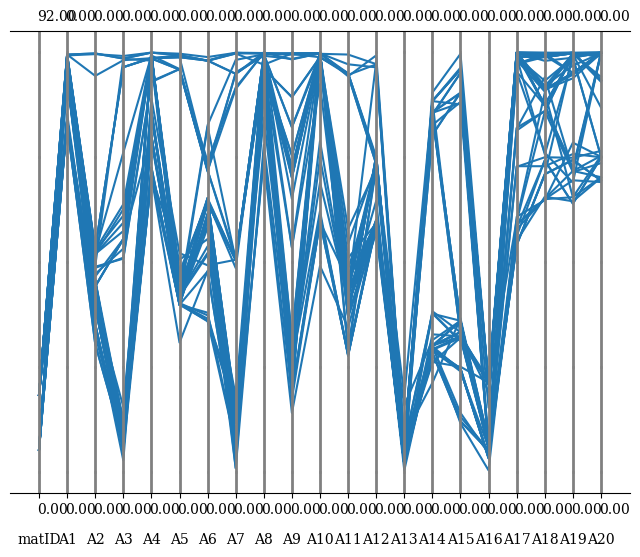

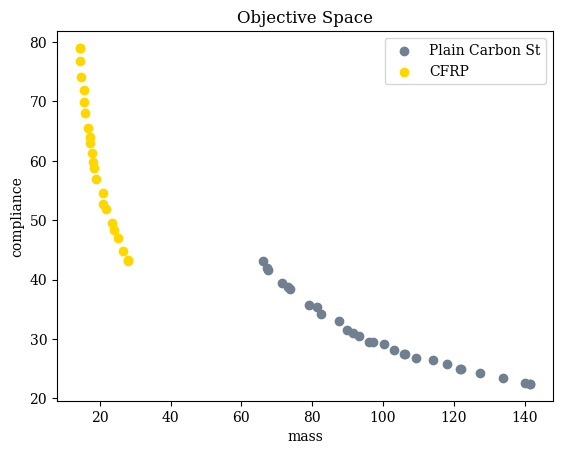

[[1.70000000e+01 9.92839828e-04 9.95925958e-04 ... 9.96709160e-04
  9.98573501e-04 9.99700084e-04]
 [5.00000000e+00 8.52878488e-04 3.94813672e-04 ... 6.48286451e-04
  7.85162903e-04 7.51572683e-04]
 [1.70000000e+01 8.22843957e-04 3.27331789e-04 ... 6.52008215e-04
  7.17786771e-04 7.02978848e-04]
 ...
 [1.70000000e+01 9.41781159e-04 4.43039706e-04 ... 9.11515817e-04
  9.51379248e-04 9.97891532e-04]
 [1.70000000e+01 9.37782654e-04 3.92888028e-04 ... 7.43037558e-04
  6.39933561e-04 7.49222784e-04]
 [1.70000000e+01 9.41781159e-04 4.43039706e-04 ... 9.11515817e-04
  9.38393925e-04 9.97891532e-04]]


In [11]:
from pymoo.visualization.pcp import PCP
X = res.X
F = res.F
G = res.G
Z_res = [[d['x01']] for d in X]




labels = list(res.opt[0].X.keys())
labels_x = ['matID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20']
bounds = np.array([problem.vars[name].bounds for name in labels]).T


X = np.array([[sol.X[name] for name in labels] for sol in res.opt])

plot1 = PCP(labels=labels_x, bounds=bounds)
plot1.set_axis_style(color="grey", alpha=1)
plot1.add(X)

plot1.show()
plt.savefig('./figures_Advanced/PCP.png',bbox_inches='tight', dpi = 200)


# Maybe the solution is limited by the limits in areas. Example, you want to minimize the compliance but
# you have a maximum area, so you can't reduce the compliance further

upper_bounds = bounds[1, 1:]*0.999
lower_bounds = bounds[0, 1:]*1.001



# Check if each row of X is within the limits
is_within_limits = np.logical_and(np.all(X[:,1:] >= lower_bounds, axis=1), np.all(X[:,1:] <= upper_bounds, axis=1))

# Print the results
if np.all(is_within_limits):
    print("Solution not limited by the areas")
else:
    print("Solution limited by the areas")



    

names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}
material_name_dict = {}  # Dictionary to map material types to material names

for xData in Z_res:
    matname = dataIdentifier['name'][int(xData[0])]
    mattype = dataIdentifier['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    material_name_dict[mattype] = matname  # Populate the material name dictionary

unique_labels = list(set(types))

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))

# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = material_name_dict[mattype]  # Use material name as the label
    ax.scatter(x, y, color=color, label=label)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)

# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(material_name_dict[label])  # Use material name as the label
    legend_dict[label].set_color(mat_colors[label])

ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Advanced/3Dcompliance_mass.png', bbox_inches='tight', dpi=200)
plt.show()
print(X)